In [1]:
import numpy as np
from matplotlib.pyplot import figure
from numba import njit
import matplotlib.pyplot as plt
import time

from pygments.styles.dracula import background

fastmath = False

angles = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                   [np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9, 4*np.pi/9],
                   [np.pi, 17*np.pi/18, 5*np.pi/9, 5*np.pi/9, 17*np.pi/18],
                   [5*np.pi/9, 17*np.pi/18, np.pi, 17*np.pi/18, 5*np.pi/9],
                   [4*np.pi/9, np.pi/2, np.pi/2, 4*np.pi/9, np.pi/9]])


#-----------------------------------------------------------
# 1. Create the initial system configuration.
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=True)
def polymergenerator(polymerl, headl):
    # Center-of-mass (COM)
    COM = np.array([5.0, 2.44, 0])
    # Create a linear polymer: each row is a 3D coordinate (x, y, z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i)
        polymer[i, 1] = 0.0
        polymer[i, 2] = 0.0

    # Create polymer surface as 13 copies of the polymer,
    # each shifted in the y-z plane by an offset on a circle (radius 0.5)
    num_copies = 14
    polymersurfaceP = np.empty((polymerl * num_copies, 3))
    polymersurfaceN = np.empty((polymerl * num_copies, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        # Compute the offset for this copy (circle in y-z plane)
        offset0 = 0.0
        offset1 = 2 * np.cos(angle)
        offset2 = 2 * np.sin(angle)
        for i in range(polymerl):
            polymersurfaceP[k * polymerl + i, 0] = polymer[i, 0] + offset0
            polymersurfaceP[k * polymerl + i, 1] = polymer[i, 1] + offset1
            polymersurfaceP[k * polymerl + i, 2] = polymer[i, 2] + offset2
            polymersurfaceN[k * polymerl + i, 0] = polymersurfaceP[k * polymerl + i, 0] + 0.068
            polymersurfaceN[k * polymerl + i, 1] = polymersurfaceP[k * polymerl + i, 1] + 0.0
            polymersurfaceN[k * polymerl + i, 2] = polymersurfaceP[k * polymerl + i, 2] + 0.0

    # Create head surface (4 atoms) as COM plus predefined offsets
    offsets = np.array([[0.2, 0.0, 0.0],
                        [0.0, 0.2, 0.0],
                        [-0.2, 0.0, 0.0],
                        [-0.034, -0.197, 0.0],
                        [0.034, -0.197, 0.0]])
    headsurface = COM + offsets
    return polymer, COM, headsurface, polymersurfaceP, polymersurfaceN


#-----------------------------------------------------------
# 2. Force calculation functions.
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=True)
def lj_brownian(a, b, epsilon, sigma):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        #if sigma/dist>0.1:
        #    dist = sigma/10
        f_val = 24 * epsilon * (-2 * (sigma ** 12 / (dist ** 13)) + (sigma ** 6 / (dist ** 7)))
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=True)
def lj_repulsive(a, b, epsilon=0.1, sigma=1):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        #if sigma/dist > 1 :
        #   dist = sigma
        f_val = -48 * epsilon * (sigma ** 12 / (dist ** 13))
        inv_dist = 1.0 / dist
        f_total[0] += f_val * dif0 * inv_dist
        f_total[1] += f_val * dif1 * inv_dist
        f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit(fastmath=fastmath, cache=True)
def harmonic_angle(surface, COM, n, angles, K=10.0, theta=np.pi / 2):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        j = (i + n) % N
        # Compute vectors from COM to surface atoms
        ab0 = surface[i, 0] - COM[0]
        ab1 = surface[i, 1] - COM[1]
        ab2 = surface[i, 2] - COM[2]
        bc0 = surface[j, 0] - COM[0]
        bc1 = surface[j, 1] - COM[1]
        bc2 = surface[j, 2] - COM[2]
        ab_norm = np.sqrt(ab0 * ab0 + ab1 * ab1 + ab2 * ab2)
        bc_norm = np.sqrt(bc0 * bc0 + bc1 * bc1 + bc2 * bc2)
        if ab_norm == 0.0 or bc_norm == 0.0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
            continue
        cos_angle = (ab0 * bc0 + ab1 * bc1 + ab2 * bc2) / (ab_norm * bc_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0
        angle_diff = angles[n,i] - np.arccos(cos_angle)
        # Compute cross products for the double cross product force
        cross_inner0 = bc1 * ab2 - bc2 * ab1
        cross_inner1 = bc2 * ab0 - bc0 * ab2
        cross_inner2 = bc0 * ab1 - bc1 * ab0
        vec0 = ab1 * cross_inner2 - ab2 * cross_inner1
        vec1 = ab2 * cross_inner0 - ab0 * cross_inner2
        vec2 = ab0 * cross_inner1 - ab1 * cross_inner0
        vec_norm = np.sqrt(vec0 * vec0 + vec1 * vec1 + vec2 * vec2)
        if vec_norm != 0.0:
            factor = -2 * K * angle_diff / vec_norm
            force[i, 0] = factor * vec0
            force[i, 1] = factor * vec1
            force[i, 2] = factor * vec2
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


@njit(fastmath=fastmath, cache=True)
def harmonic_surface(surface, COM, epsilon=10, sigma=0.2):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx * dx + dy * dy + dz * dz)
        if norm_val > 0:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


#-----------------------------------------------------------
# 3. Define the integration function (Not-Verlet algorithm)
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=True)
def notverlet(COM, surface, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN):
    # Compute harmonic angle forces and sum them
    N = surface.shape[0]
    force1 = harmonic_angle(surface, COM, 1, angles)
    force2 = harmonic_angle(surface, COM, 2, angles)
    force3 = harmonic_angle(surface, COM, -2, angles)
    force4 = harmonic_angle(surface, COM, -1, angles)

    angle_forces = force1 + force2 + force3 + force4

    # Compute harmonic bond force
    harmonic_bond = harmonic_surface(surface, COM)

    # Compute Lennard-Jones (Brownian) force on a particular surface atom (index 3)
    lj_force_surf = np.zeros_like(surface)
    lj_force_surf[3] = lj_brownian(polymersurfaceP, surface[3], 0.001, 0.2)
    lj_force_surf[4] = lj_brownian(polymersurfaceN, surface[4], 0.001, 0.2)
    delta_surface = np.empty_like(surface)
    # Update surface positions
    for i in range(surface.shape[0]):
        for j in range(3):
            delta_surface[i,j] = dt * (
                        (angle_forces[i, j] + harmonic_bond[i, j] + lj_force_surf[i, j]) + np.random.uniform(-random_val, random_val) )
        displacement = np.sqrt(delta_surface[i,0]**2 + delta_surface[i,1]**2 + delta_surface[i,2]**2)
        #if displacement > 0.1: delta_surface= 0.1*delta_surface/displacement
    new_surface = np.empty_like(surface)
    for i in range(surface.shape[0]):
        for j in range(3):
            new_surface[i, j] = (surface[i, j] + delta_surface[i,j])
                                 #dt * ((angle_forces[i, j] + harmonic_bond[i, j] + lj_force_surf[i, j]) + 0.1*np.random.uniform(-random_val, random_val) ))
    # Compute repulsive force on COM from polymer
    lj_force_COM = lj_repulsive(polymer, COM, 0.001, 2.05)
    # Sum harmonic bond forces over surface atoms (exclude angle forces per corrected dynamics)
    harmonic_sum = np.zeros(3)
    for i in range(harmonic_bond.shape[0]):
        harmonic_sum[0] += harmonic_bond[i, 0]
        harmonic_sum[1] += harmonic_bond[i, 1]
        harmonic_sum[2] += harmonic_bond[i, 2]

    # Update COM position
    delta_COM = np.empty(3)
    for i in range(3):
        delta_COM[i] = dt * (mu * (lj_force_COM[i] - harmonic_sum[i]) + np.random.uniform(-random_val, random_val))
    displacement = np.sqrt(delta_COM[0]**2+delta_COM[1]**2+delta_COM[2]**2)
    #if displacement > 0.1: delta_COM = 0.1*delta_COM/displacement
    new_COM = np.empty(3)
    for i in range(3):
        new_COM[i] = COM[i] + delta_COM[i]
    return new_COM, new_surface


#-----------------------------------------------------------
# 4. Define the simulation loop.
#    Progress messages are printed every 'print_every' steps.
#-----------------------------------------------------------
@njit(fastmath=fastmath, cache=True)
def simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN, steps, dt, random_val, mu, print_every, hist_every=1000):
    histsize = steps // hist_every
    headhist = np.empty((histsize, 3))
    surfacehist = np.empty((histsize, surface.shape[0], 3))
    headhist[0] = COM
    surfacehist[0] = surface
    for i in range(steps + 1):
        COM, surface = notverlet(COM, surface, dt, random_val, mu, polymer, polymersurfaceP, polymersurfaceN)
        if i % hist_every == 0:
            headhist[i // hist_every] = COM
            surfacehist[i // hist_every] = surface
        if i % print_every == 0:
            print("Step", i, "/", steps, "COM:", COM[0], COM[1], COM[2])
    return headhist, surfacehist

In [45]:
#-----------------------------------------------------------
# 5. Main simulation parameters and execution.
#-----------------------------------------------------------
polymerLength = 10
headN = 1
steps = 1000000
dt = 0.001
random_val = 1 #makeit 1
mu = 0.9
print_every = 1000000
hist_every = 10000

# Initialize the system.
polymer, COM, surface, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)

# Run the simulation (the entire simulation loop is compiled for speed).
start = time.perf_counter()
headhist, surfacehist = simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN , steps, dt, random_val, mu, print_every, hist_every)
print("Simulation complete. Final COM:", headhist[-1])
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Step 0 / 1000000 COM: 4.999794154612929 2.440005408440367 0.00024242976645132532
Step 1000000 / 1000000 COM: 5.078951633138312 2.41218152528662 0.12637821178227956
Simulation complete. Final COM: [5.05640452 2.3916286  0.1906858 ]
Elapsed (after compilation) = 1.9612667080000392s


In [55]:
surfacehist[-1]

array([[ 5.0257598 ,  3.53872302, -2.13736006],
       [ 4.79238218,  3.38275003, -2.07471758],
       [ 4.89109121,  3.17687348, -2.24561841],
       [ 5.09784866,  3.30629918, -2.32514843],
       [ 5.1268401 ,  3.3644393 , -2.30237003]])

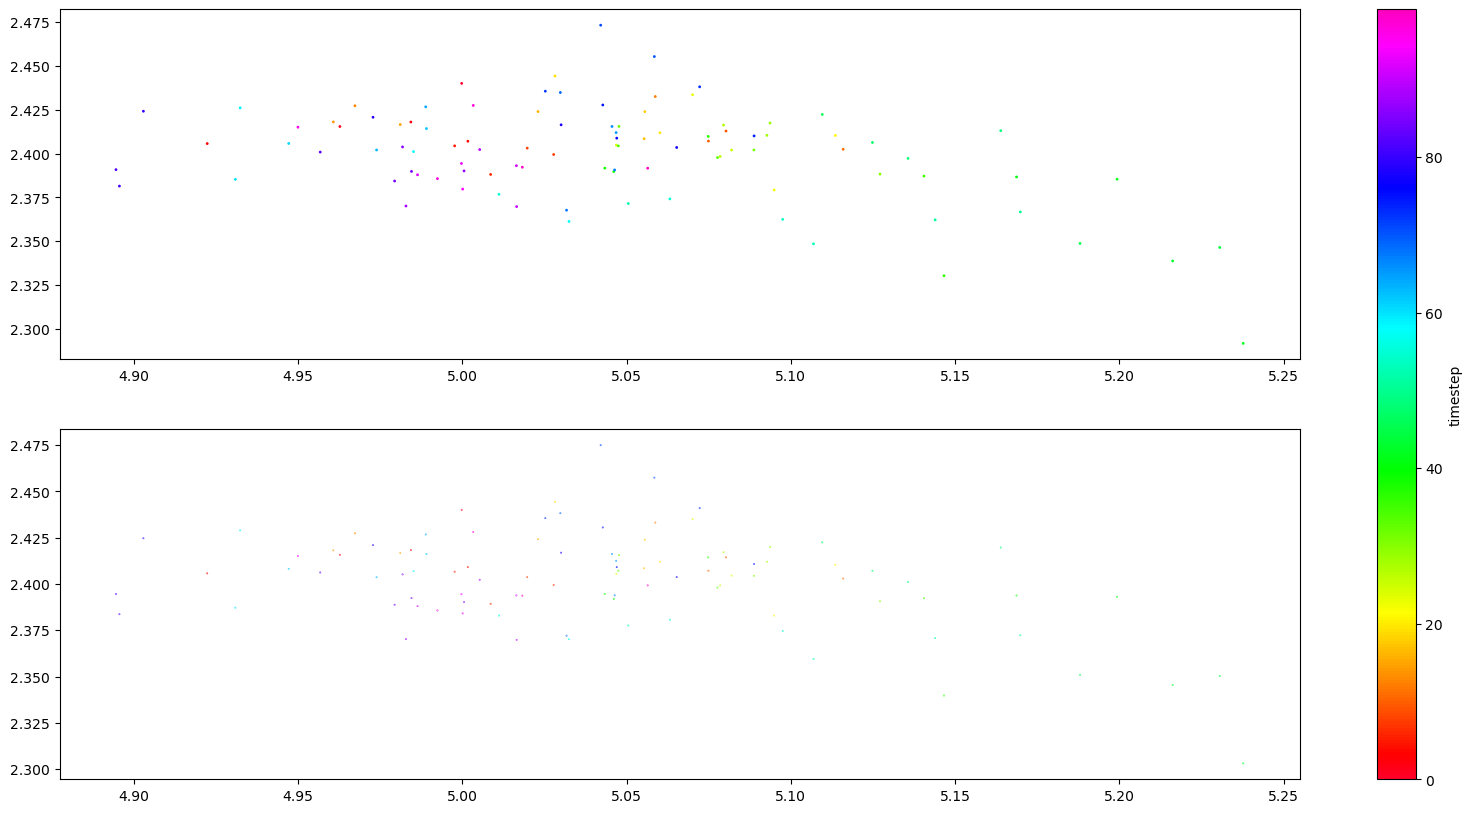

In [48]:
# (This cell uses your original plotting tools.)

render_everyN = 1
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
time_arr = np.arange(steps/(render_everyN*hist_every))



#fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
#fig, ax = plt.subplots(2,gridspec_kw={'height_ratios': [4, 4], "width_ratios": [1]}, figsize=(10,10))
fig, ax = plt.subplots(2, figsize=(20,10), dpi=100)
pos = ax[0].scatter(headhist[::render_everyN, 0], headhist[::render_everyN, 1], cmap="gist_rainbow", c=time_arr, s=1)
#ax[0].set_xlim(4.6, 6.4)
#ax[0].set_ylim(-2.4, 2.4)
#ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
#ax[1].set_xlim(-0.6, 7.4)
#ax[1].set_ylim(0.5, 4.5)
#ax[1].set_aspect("equal", adjustable="box")
fig.colorbar(pos, ax=ax, label='timestep')
plt.show()

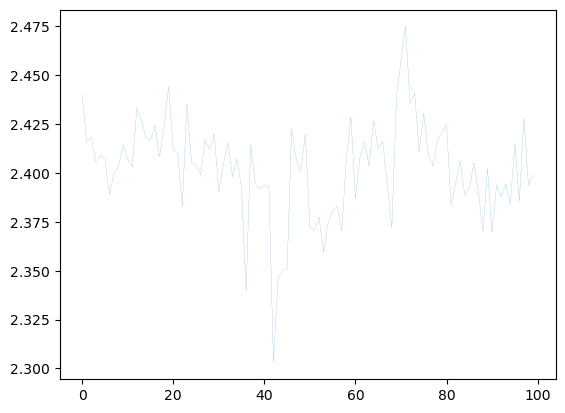

In [47]:
fig, ax = plt.subplots(dpi=100)
figigi = ax.plot(time_arr[::], orthogonal_distance[::], linewidth=0.1)

In [33]:
with open("trajectoryn.xyz", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::],(int(steps/hist_every),1,3))), surfacehist[::]),axis=1)):
        f.write(f"6 \n \n")
        f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
        f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
        f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
        f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
        f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
        f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")

In [34]:
with open("polymerrn.xyz", "w") as f:
    f.write(f"2800 \n \n")
    for i in range(polymerLength*14):
        f.write(f"C{2*i+7} {polymersurfaceP[i,0]:8.4f}{polymersurfaceP[i,1]:8.4f}{polymersurfaceP[i,2]:8.4f} \n")
        f.write(f"C{2*i+8} {polymersurfaceN[i,0]:8.4f}{polymersurfaceN[i,1]:8.4f}{polymersurfaceN[i,2]:8.4f} \n")
    #for i in range(polymerLength):
     #   f.write(f"ATOM  {i+2:5d}  C   UNK     1    {i:8.4f}{0:8.4f}{0:8.4f}  1.00  0.00           C\n")

In [ ]:
import holoviews as hv
import datashader as ds
import holoviews.operation.datashader as hd
import pandas as pd
import numpy as np

hv.extension('bokeh')

# Use the same subsampling as before
render_everyN = 1
# Create a time array for the rendered points
time_arr = np.arange(steps/(render_everyN*hist_every))

# Prepare DataFrames for the two plots.
# Plot 1: Scatter of COM x vs. COM y
df1 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': headhist[::render_everyN, 1],
    'time': headhist[::render_everyN, 0] * 0.0 + time_arr  # associate time (or use headhist if desired)
})

# Plot 2: Scatter of COM x vs. orthogonal distance
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
df2 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': orthogonal_distance,
    'time': time_arr
})

# Create Holoviews Points objects.
points1 = hv.Points(df1, kdims=['x', 'y'], vdims=['time'])
points2 = hv.Points(df2, kdims=['x', 'y'], vdims=['time'])

# Apply Datashader to each plot for interactive aggregation.
shaded1 = hd.datashade(points1, cmap="gist_rainbow", aggregator=ds.mean('time'))
shaded2 = hd.datashade(points2, cmap="gist_rainbow", aggregator=ds.mean('time'))

# Set options (titles, colorbars, dimensions, etc.)
shaded1 = shaded1.opts(title="COM Trajectory (x vs. y)",
                       frame_width=600, frame_height=400, bgcolor='black')
shaded2 = shaded2.opts(title="COM Trajectory (x vs. Orthogonal Distance)",
                       frame_width=600, frame_height=200, bgcolor='black')

# Layout the two plots vertically.
layout = hv.Layout([shaded1, shaded2]).cols(1)
layout

In [58]:
def plotter(headhistv,id, save=False):
    plt.style.use('dark_background')
    render_everyN = 1
    orthogonal_distance = np.linalg.norm(headhistv[::render_everyN, 1:3], axis=1)
    time_arr = np.arange(steps/(render_everyN*hist_every))

    #fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10), dpi=200) #gridspec_kw={'height_ratios': [4, 1], "width_ratios": [1]}
    pos = ax[0,0].scatter(headhistv[::render_everyN, 0], headhistv[::render_everyN, 1], cmap="gist_rainbow", c=time_arr, s=1)
    #ax[0].set_xlim(4.6, 6.4)
    #ax[0].set_ylim(-2.4, 2.4)
    ax[0,0].set_aspect("equal", adjustable="box")
    perp = ax[0,1].scatter(headhistv[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
    #ax[1].set_xlim(-0.6, 7.4)
    #ax[1].set_ylim(0.5, 4.5)
    ax[0,1].set_aspect("equal", adjustable="box")
    fig.colorbar(pos, ax= ax[0,1], label='timestep',)
    gs = ax[1, 0].get_gridspec()
    # remove the underlying Axes
    for ax in ax[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    figigi = axbig.plot(time_arr[::], orthogonal_distance[::], linewidth=1)
    plt.show()
    fig.savefig(f'/Users/filiproch/PycharmProjects/LAMMPS/figures/ipyruns/engine{id}.png')


Engine 0:


ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 1000.

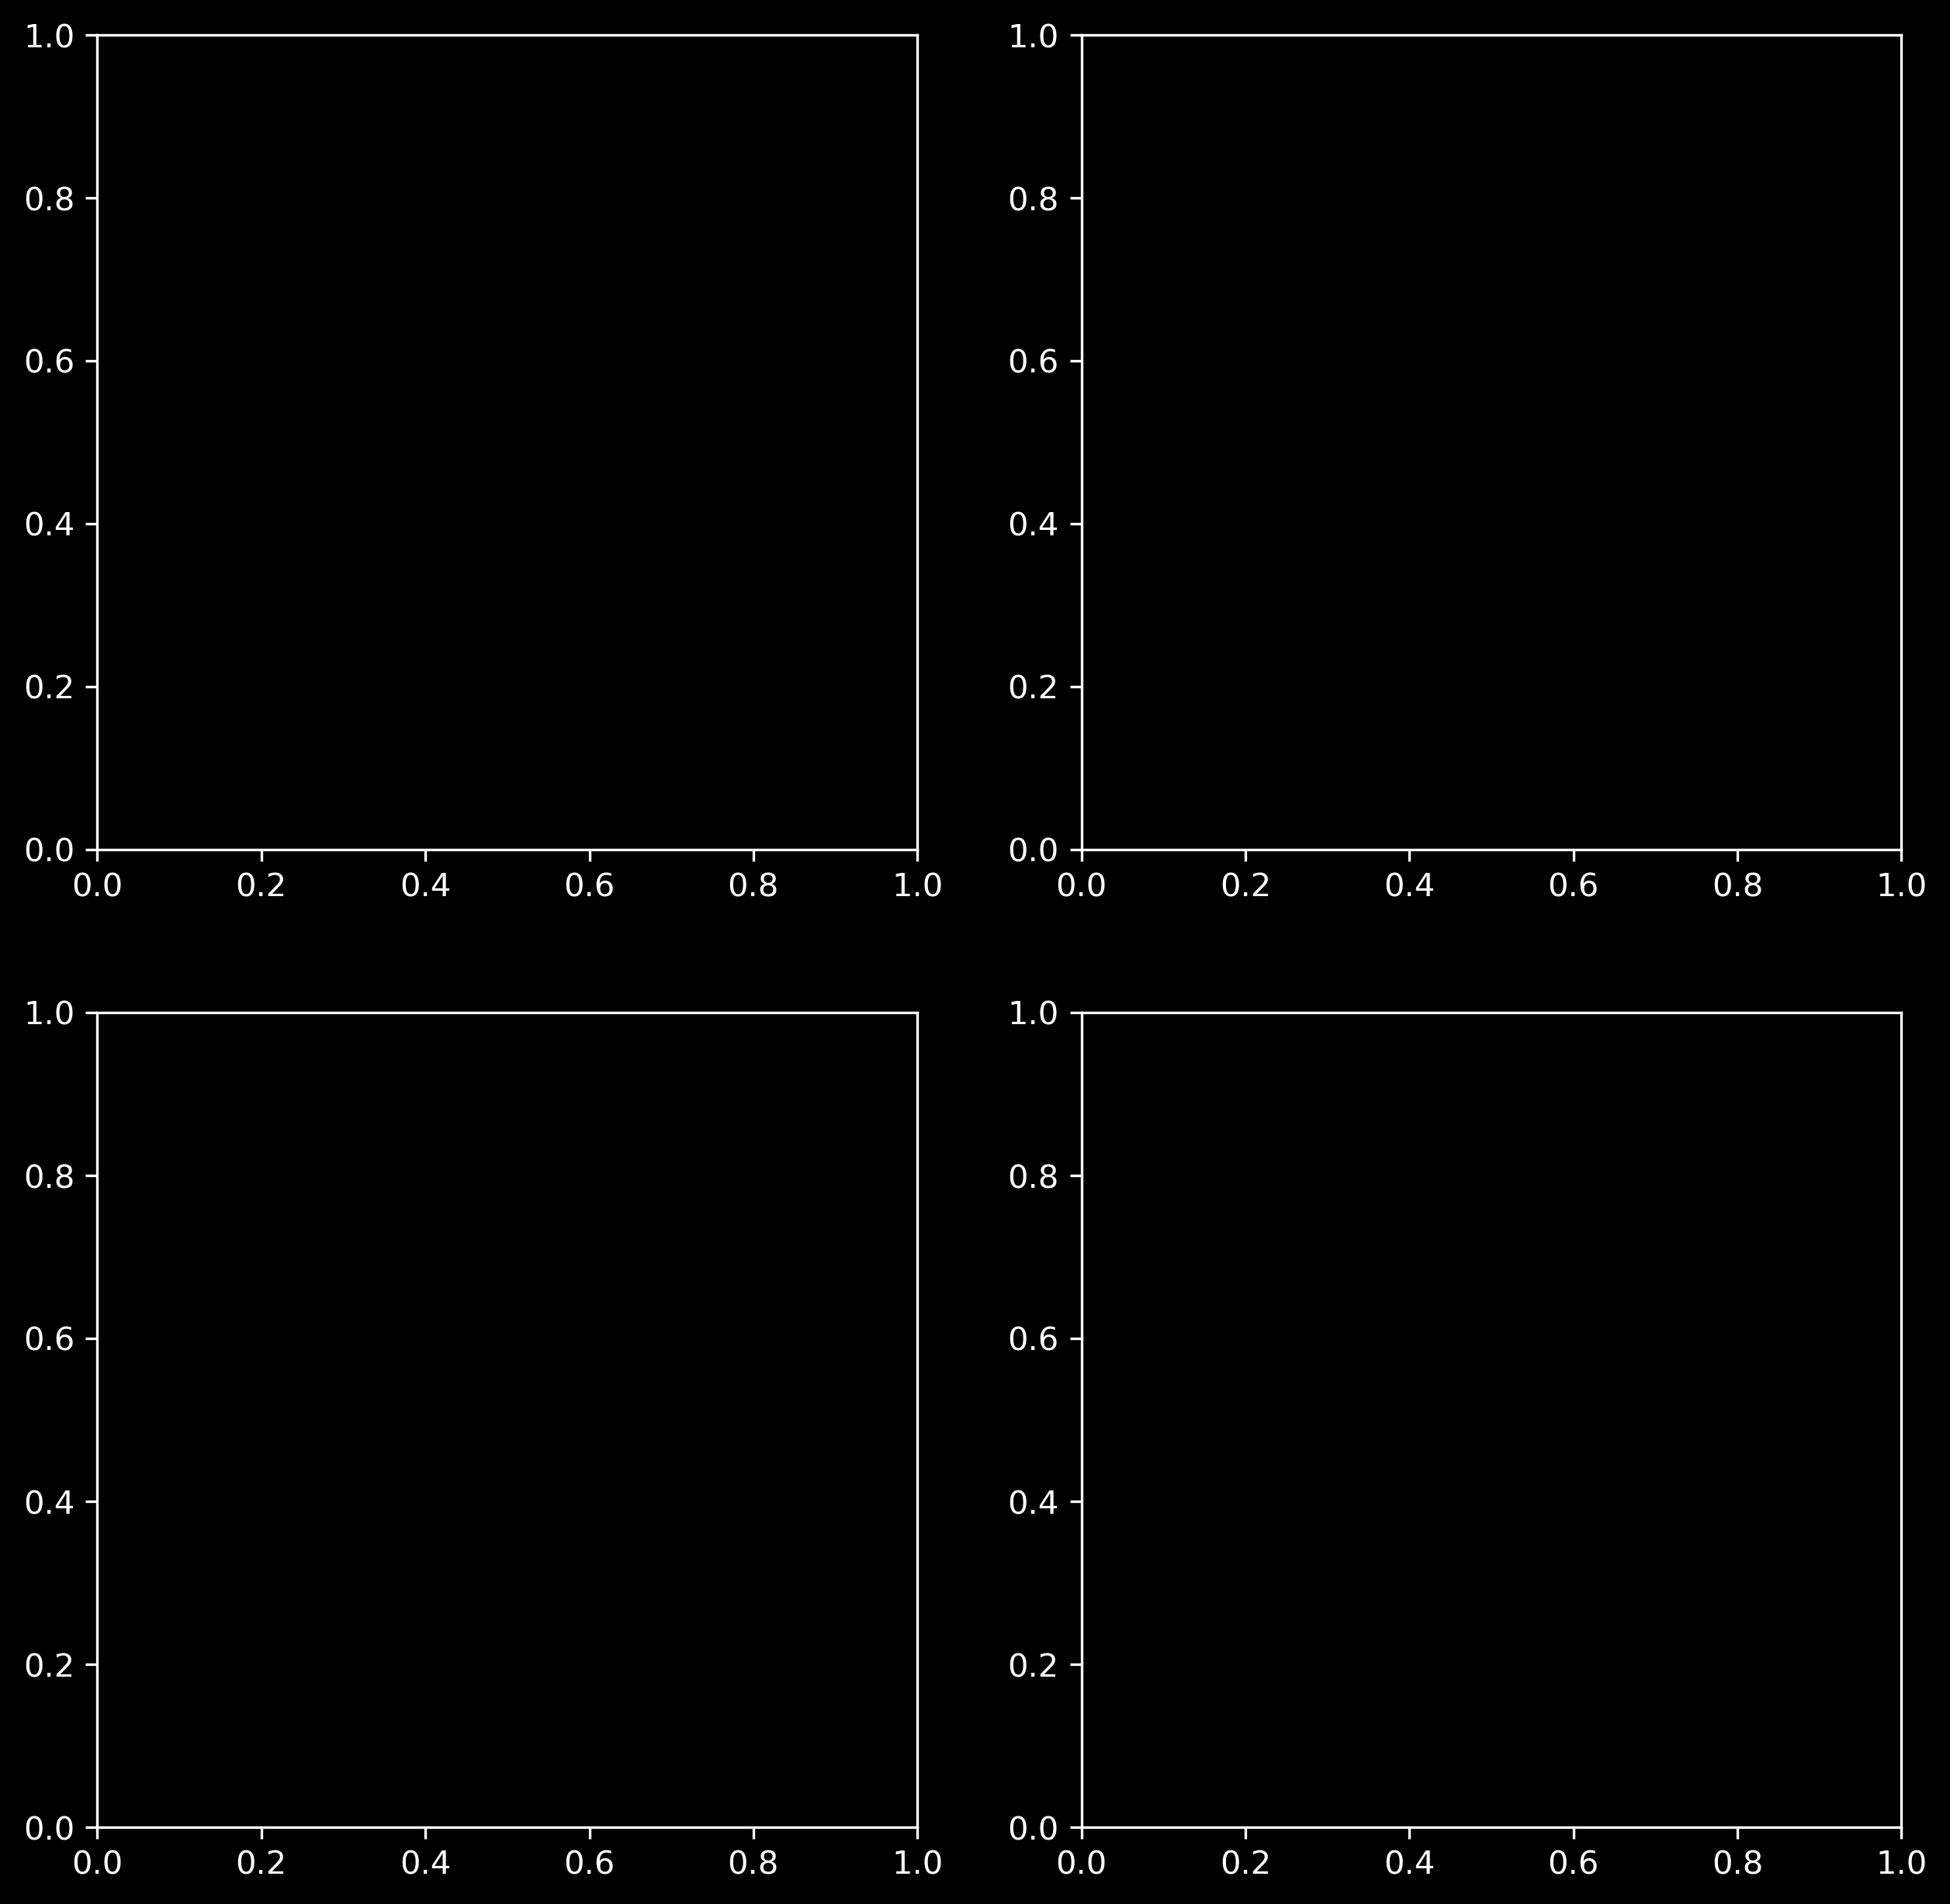

In [56]:
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    plotter(res['headhist'], idx, True)
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))


Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

importing time on engine(s)
Engine 0:
engine set stopped 1741880225: {'engines': {'0': {'exit_code': 0, 'pid': 11389, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 11393, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 11395, 'identifier': '4'}, '2': {'exit_code': 0, 'pid': 11391, 'identifier': '2'}, '5': {'exit_code': 0, 'pid': 11397, 'identifier': '5'}, '1': {'exit_code': 0, 'pid': 11390, 'identifier': '1'}}, 'exit_code': 0}


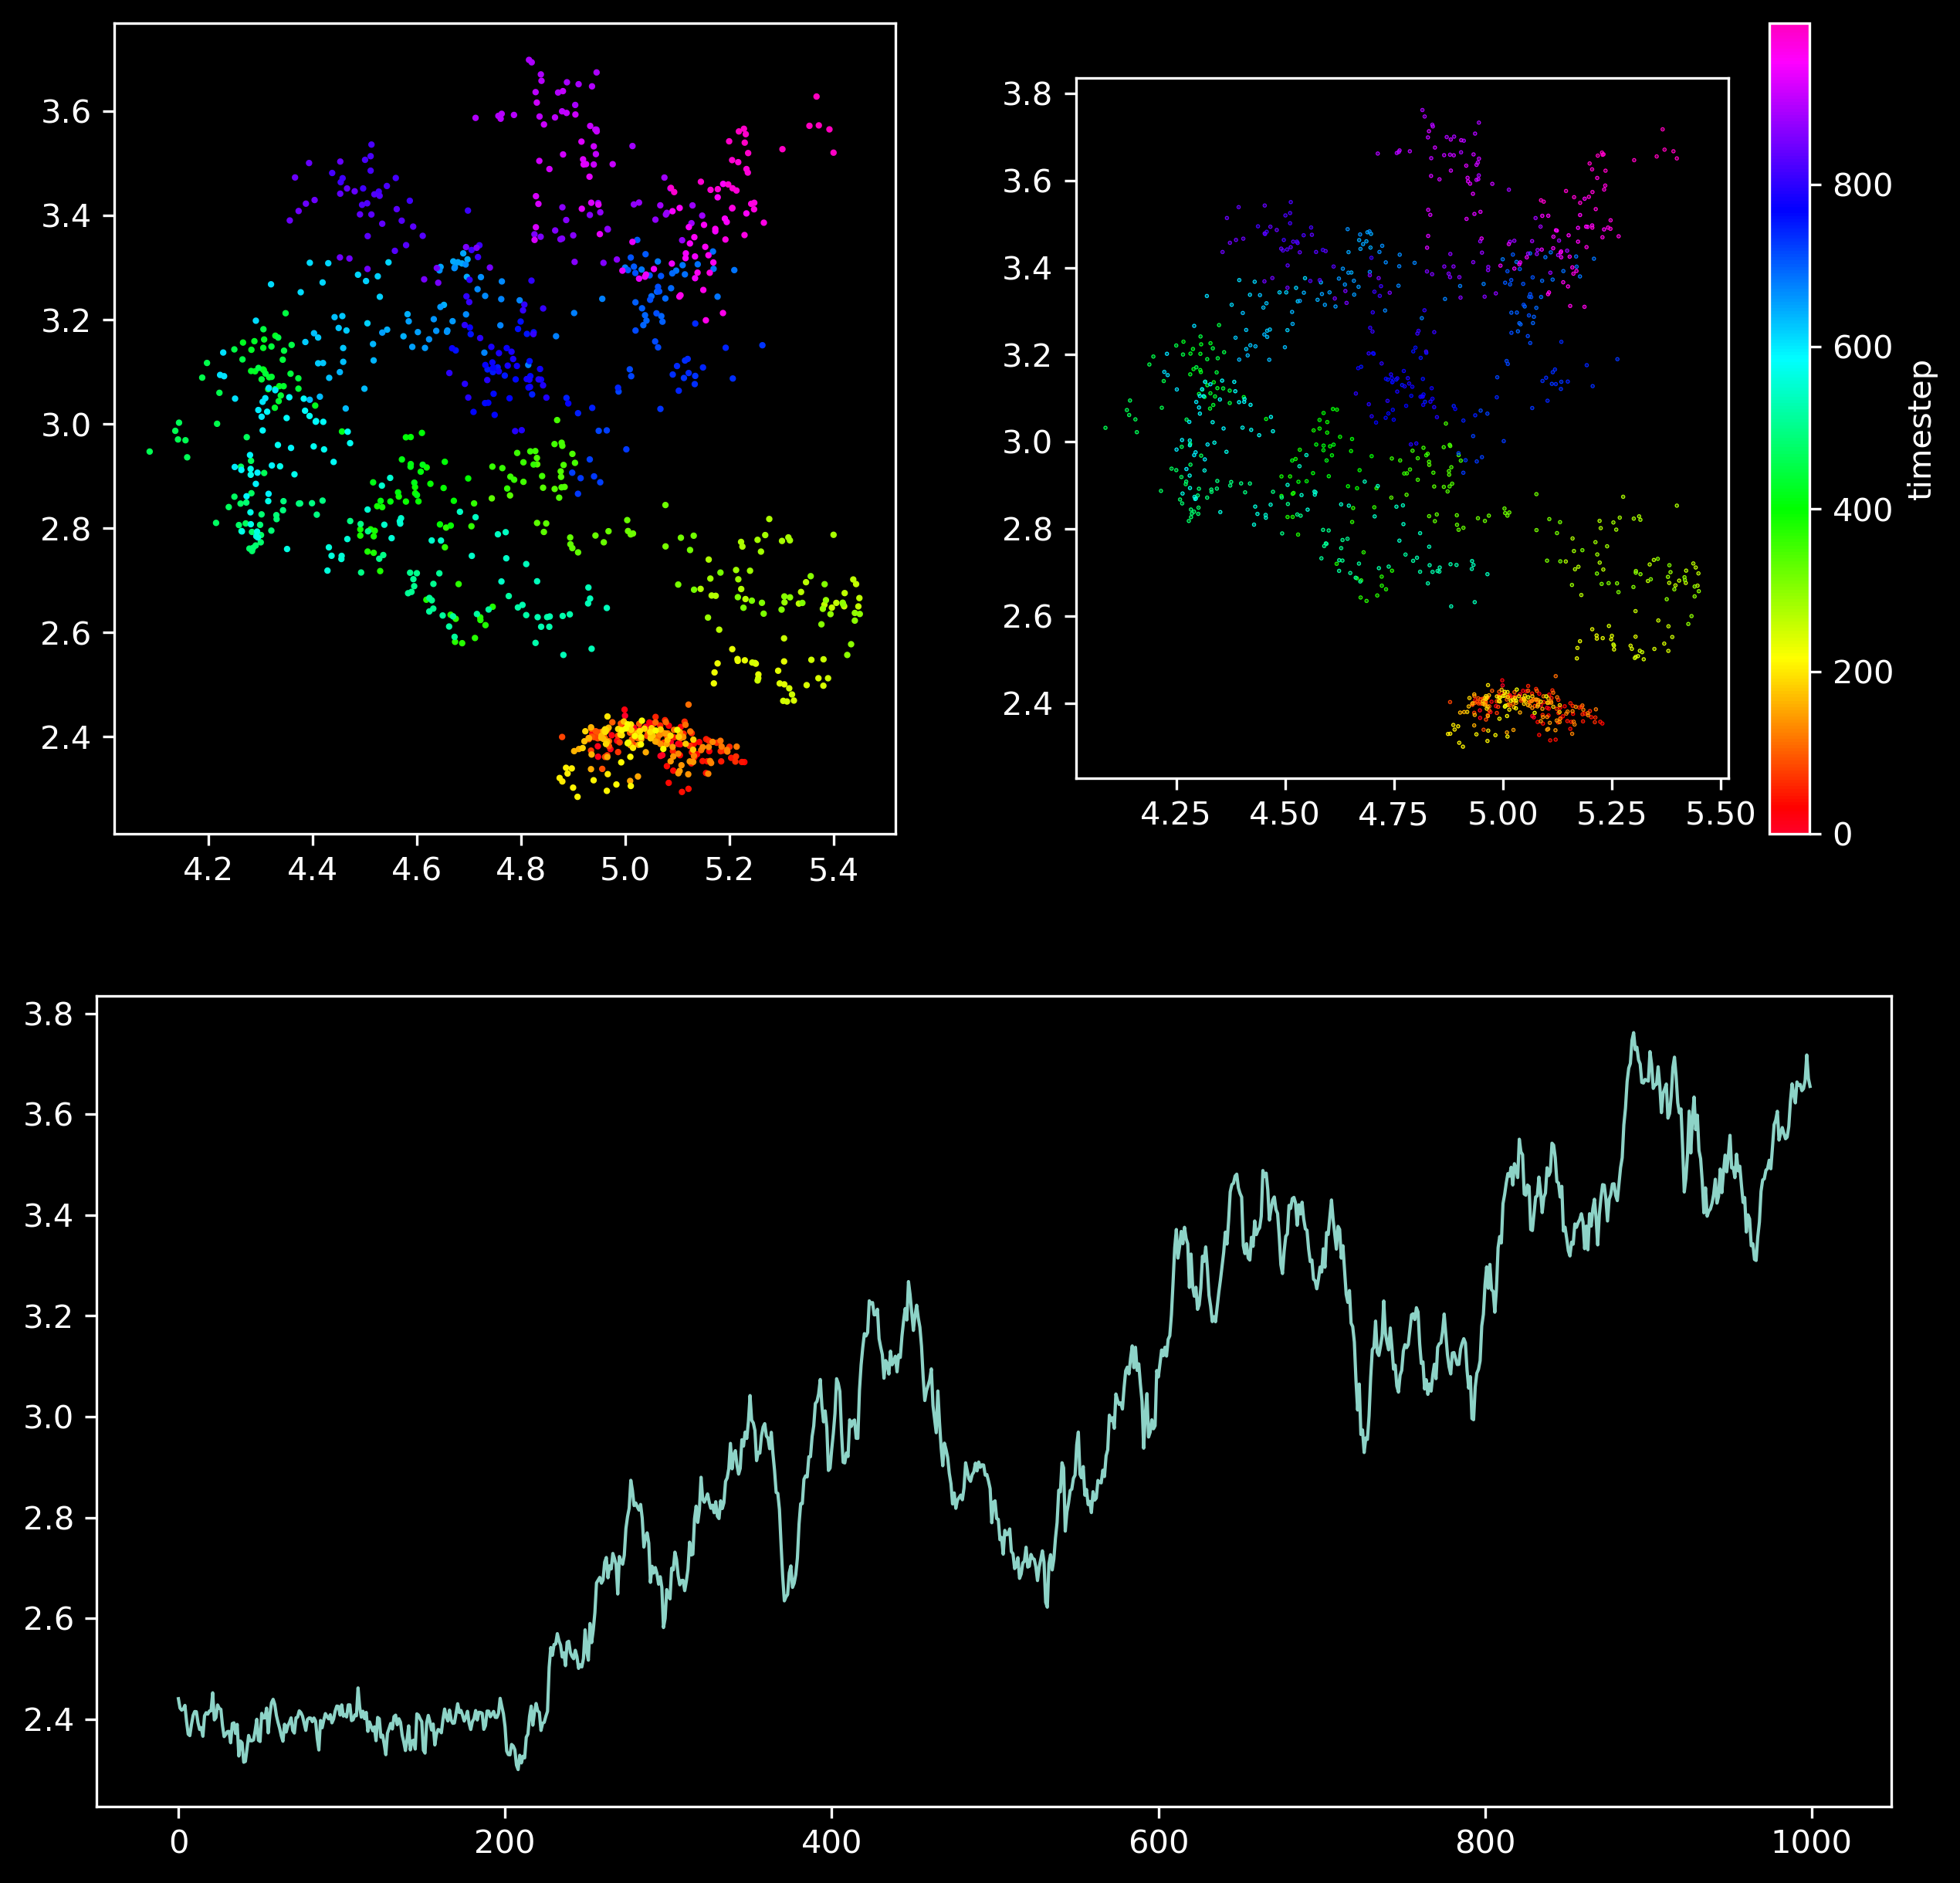

Elapsed (after compilation) = 24.469192041000497s
Engine 1:


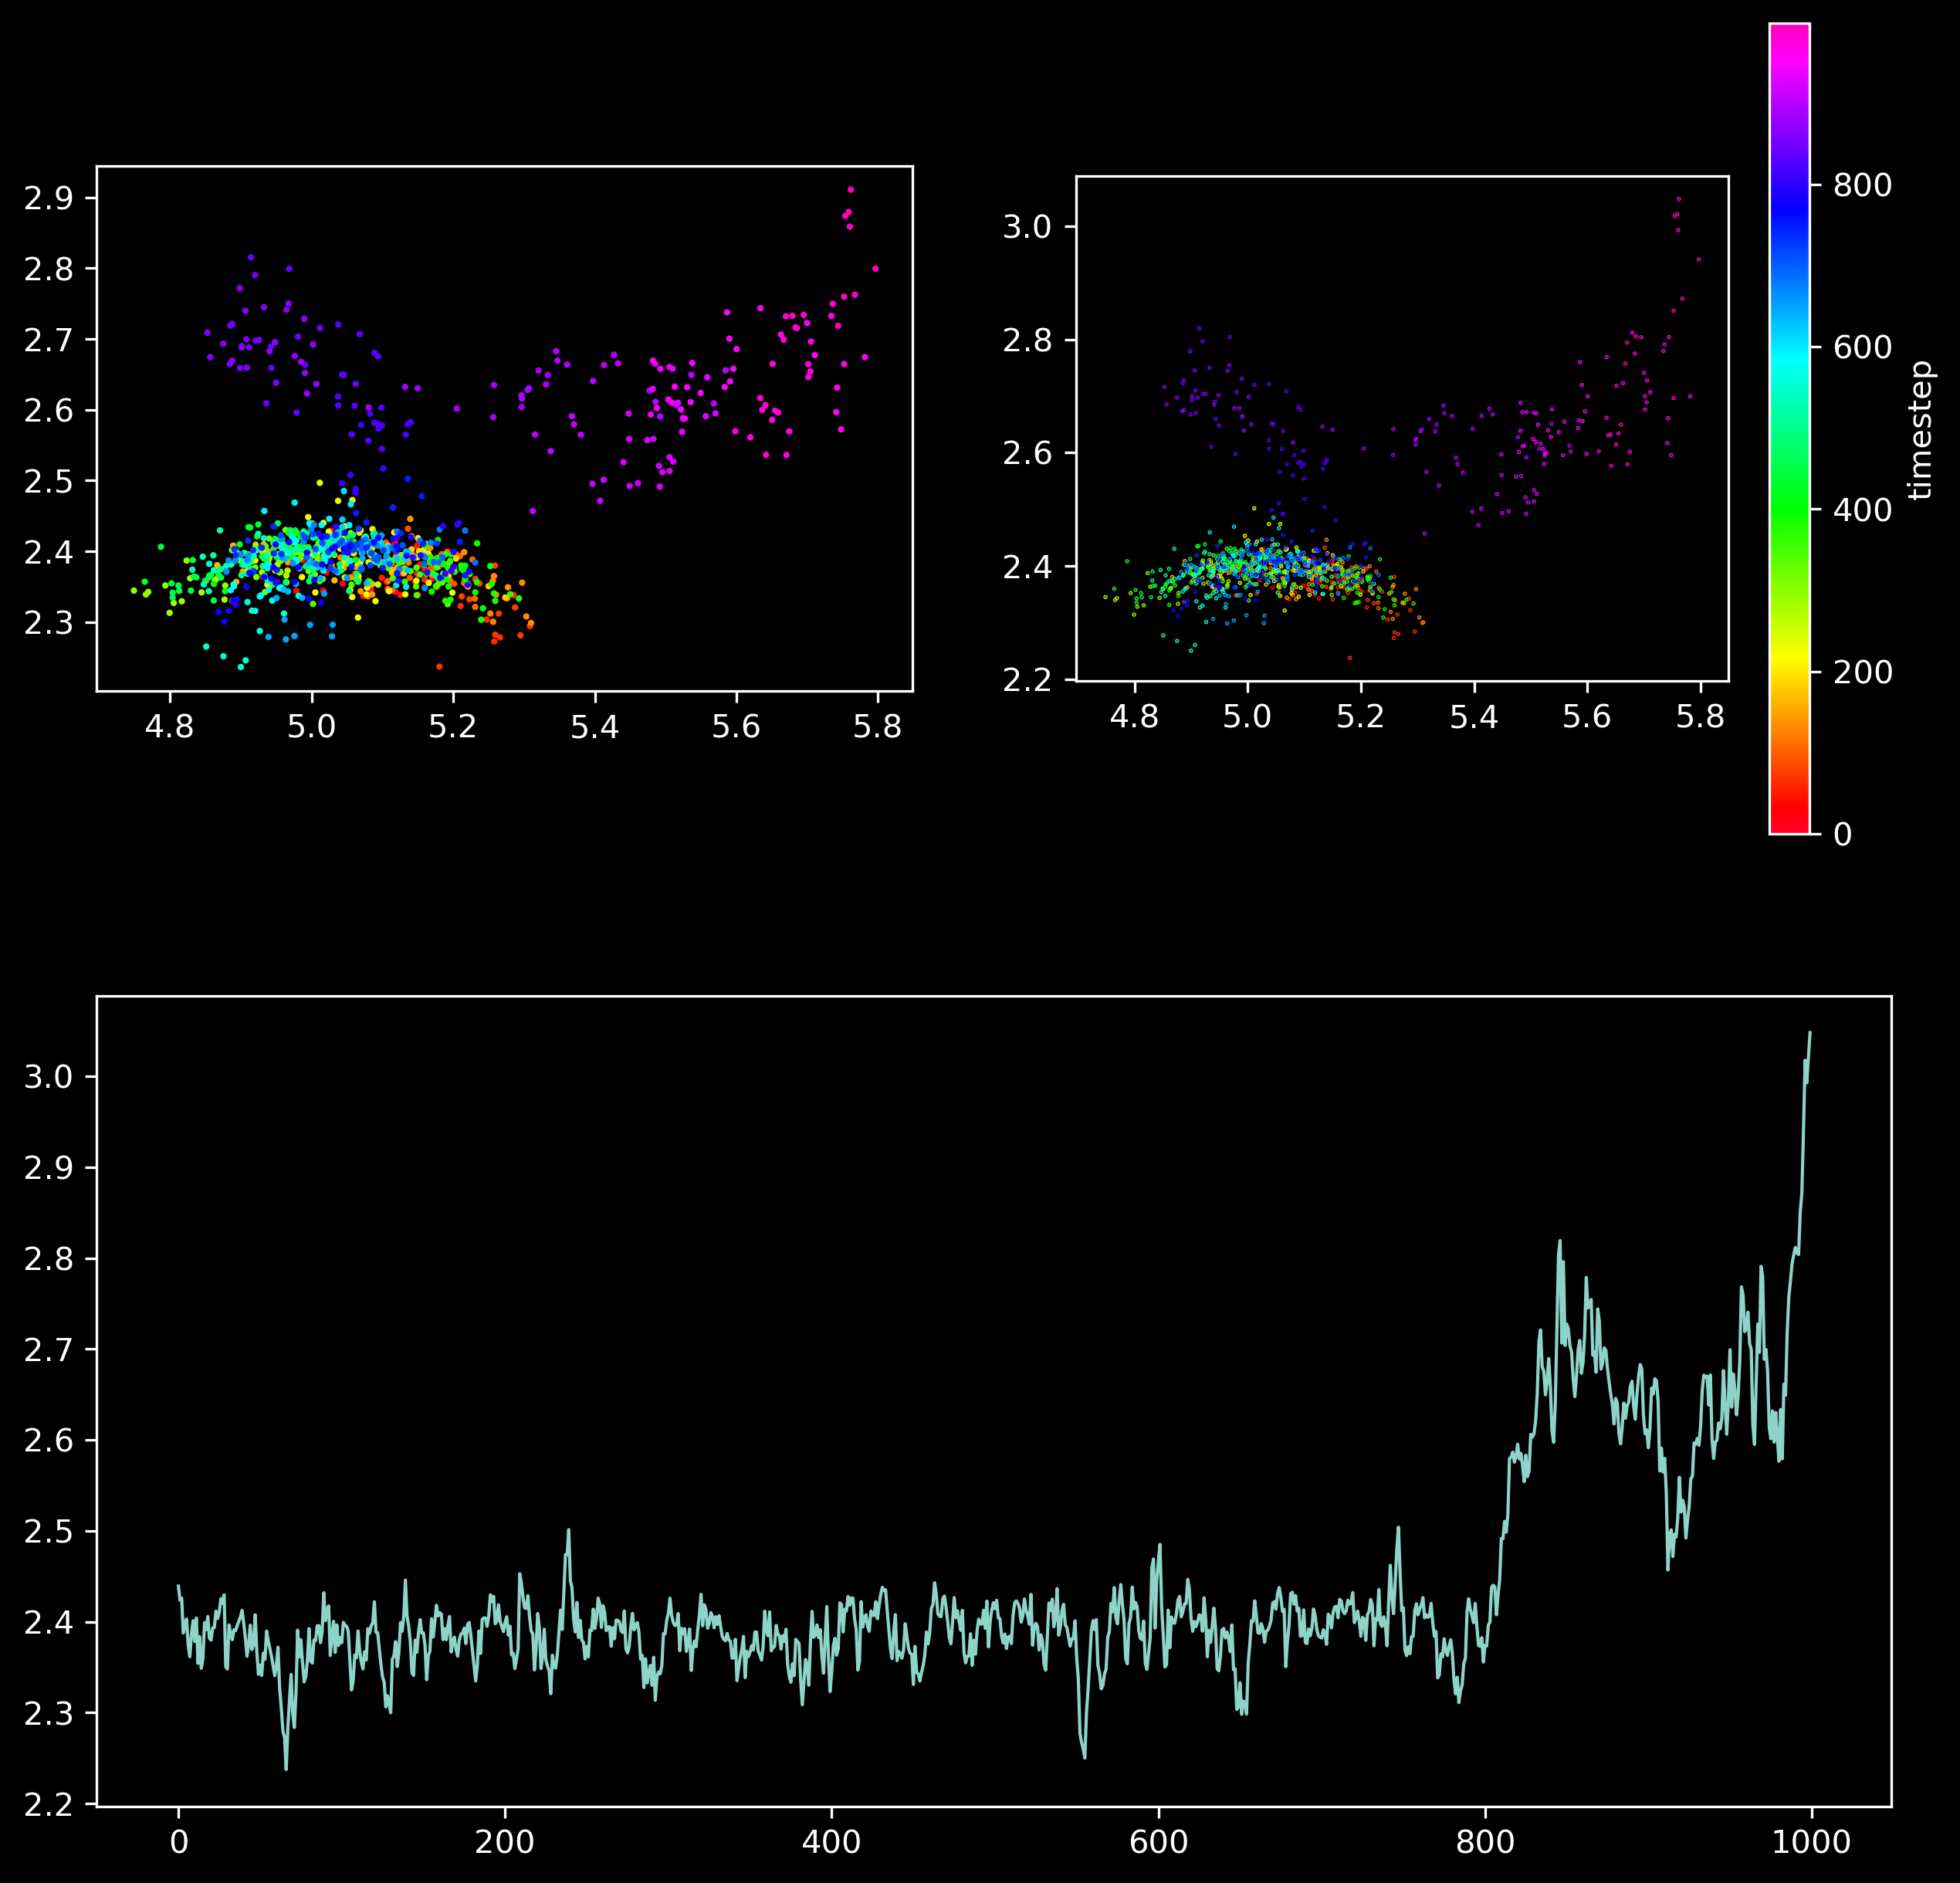

Controller stopped: {'exit_code': 0, 'pid': 11374, 'identifier': 'ipcontroller-1741880224-m2ct-9692'}
Elapsed (after compilation) = 24.6012168749985s
Engine 2:


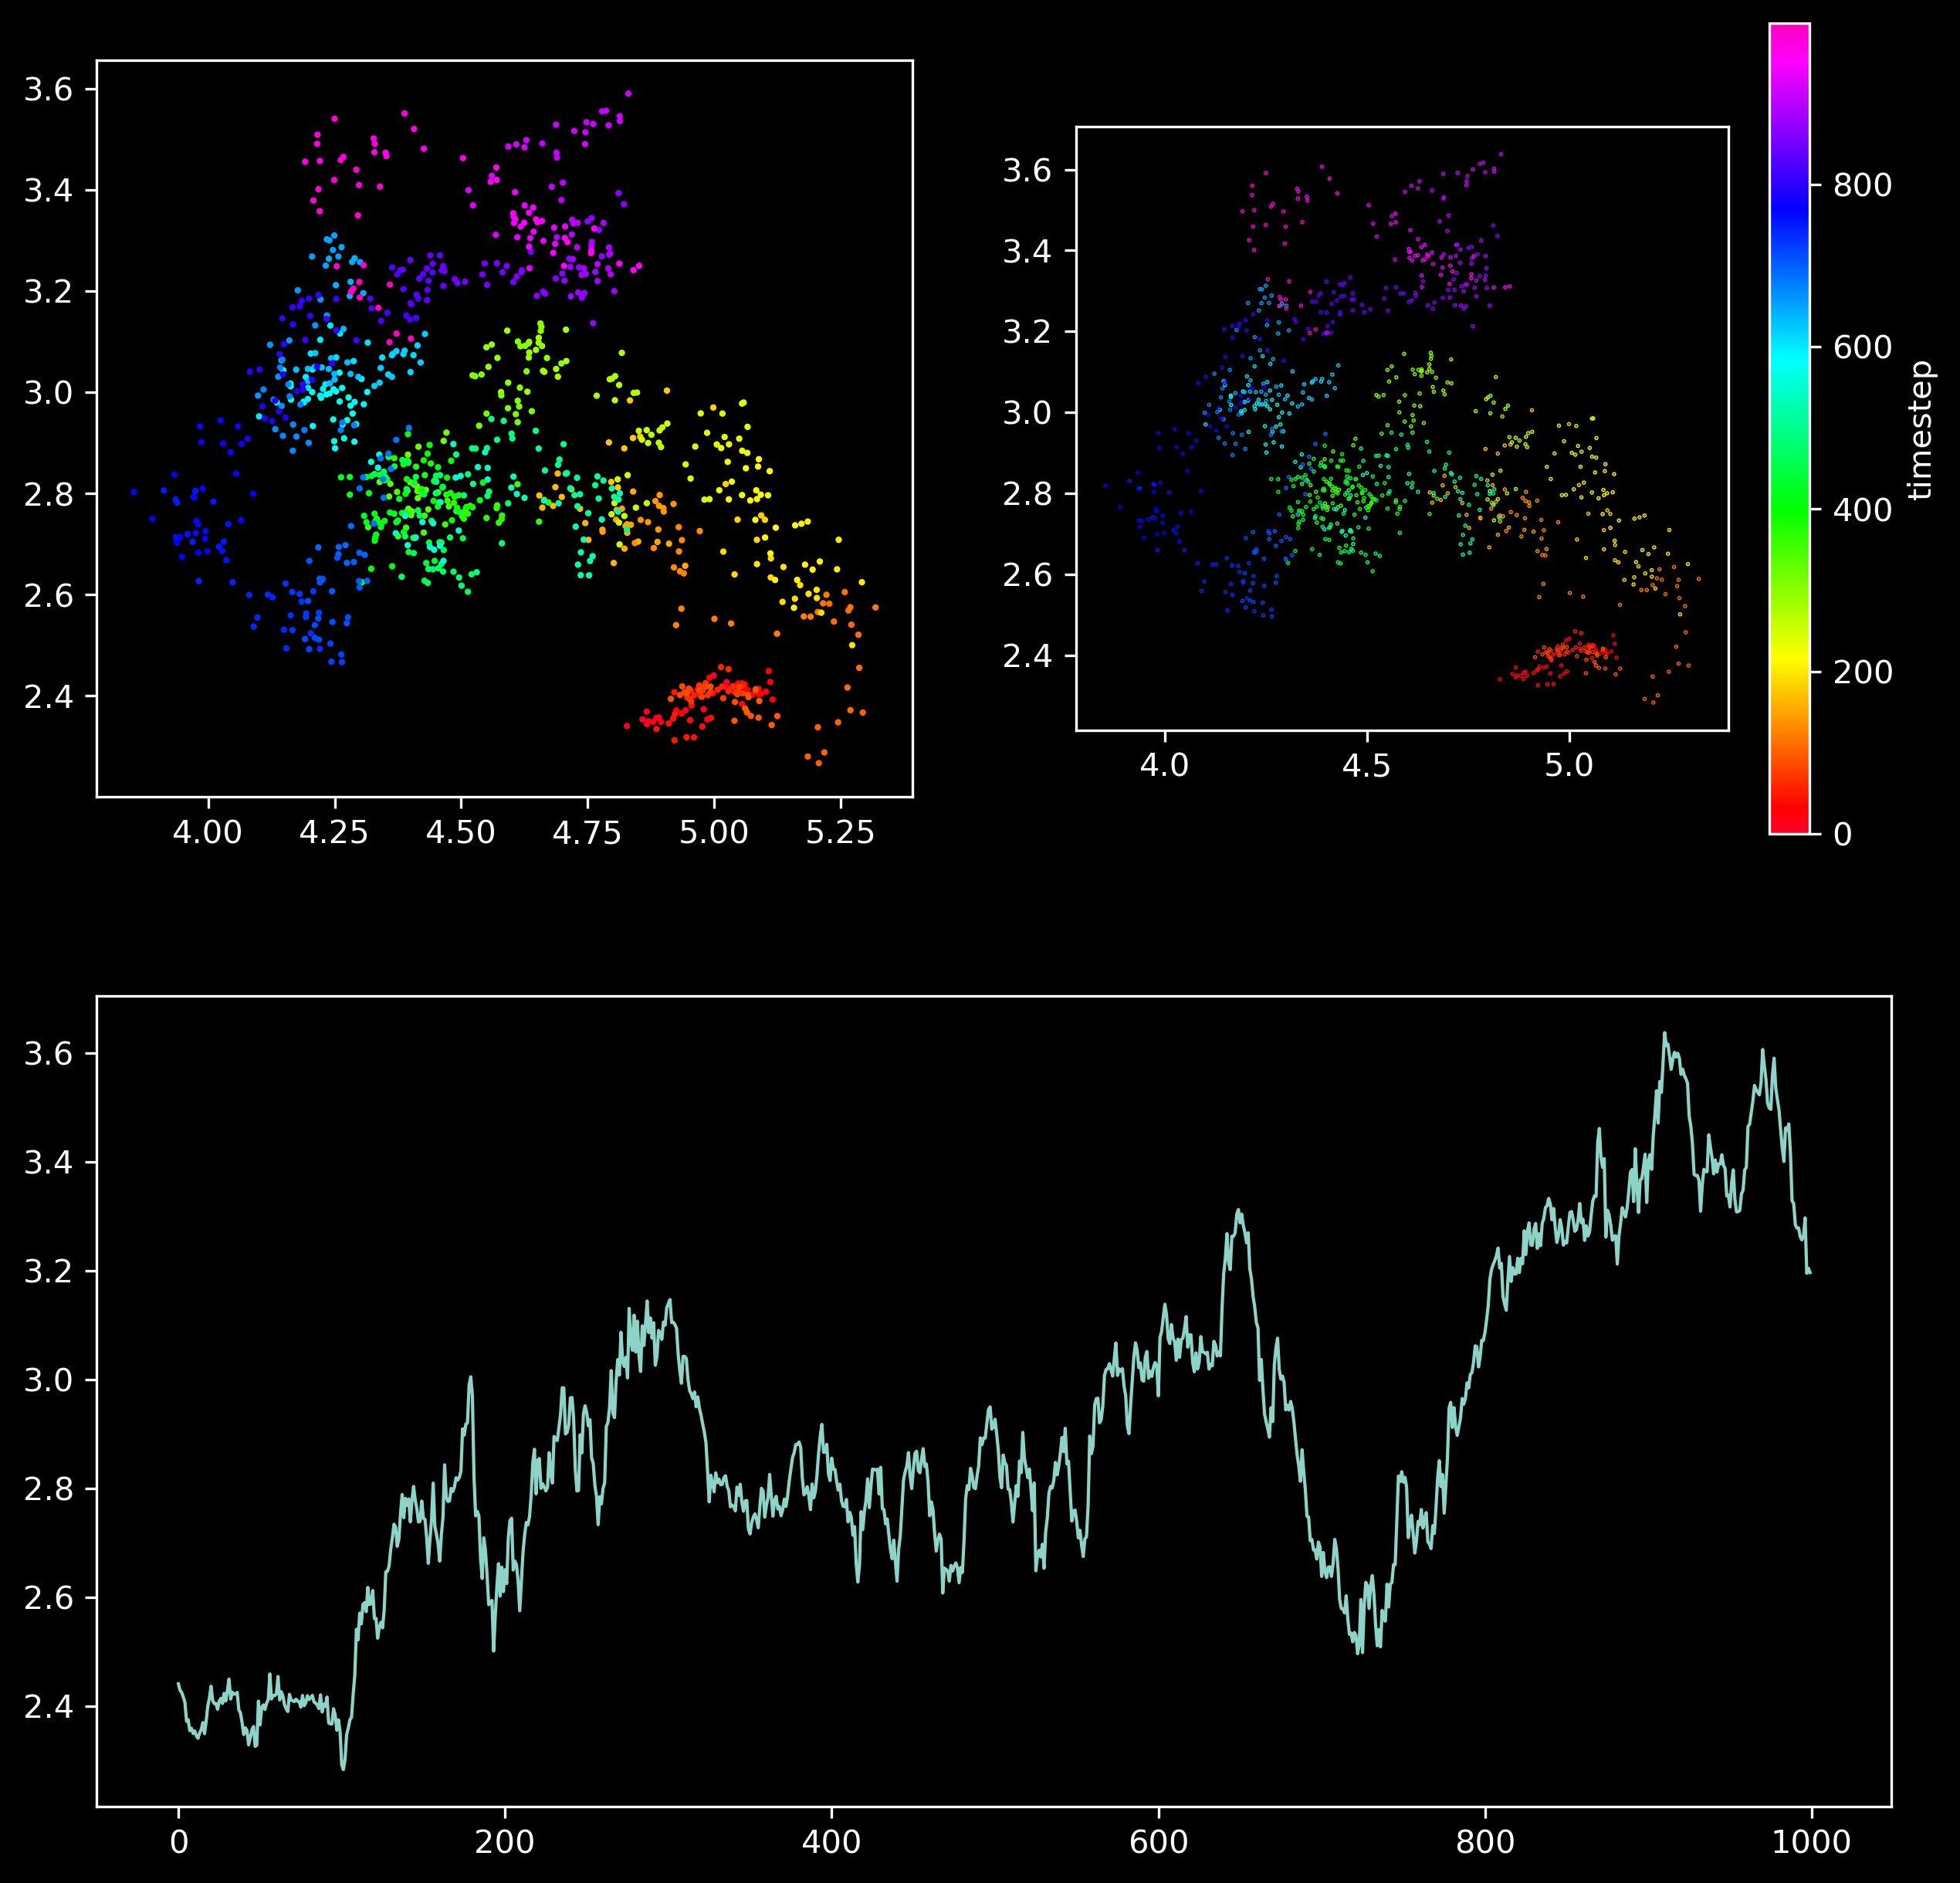

Elapsed (after compilation) = 24.873900583999784s
Engine 3:


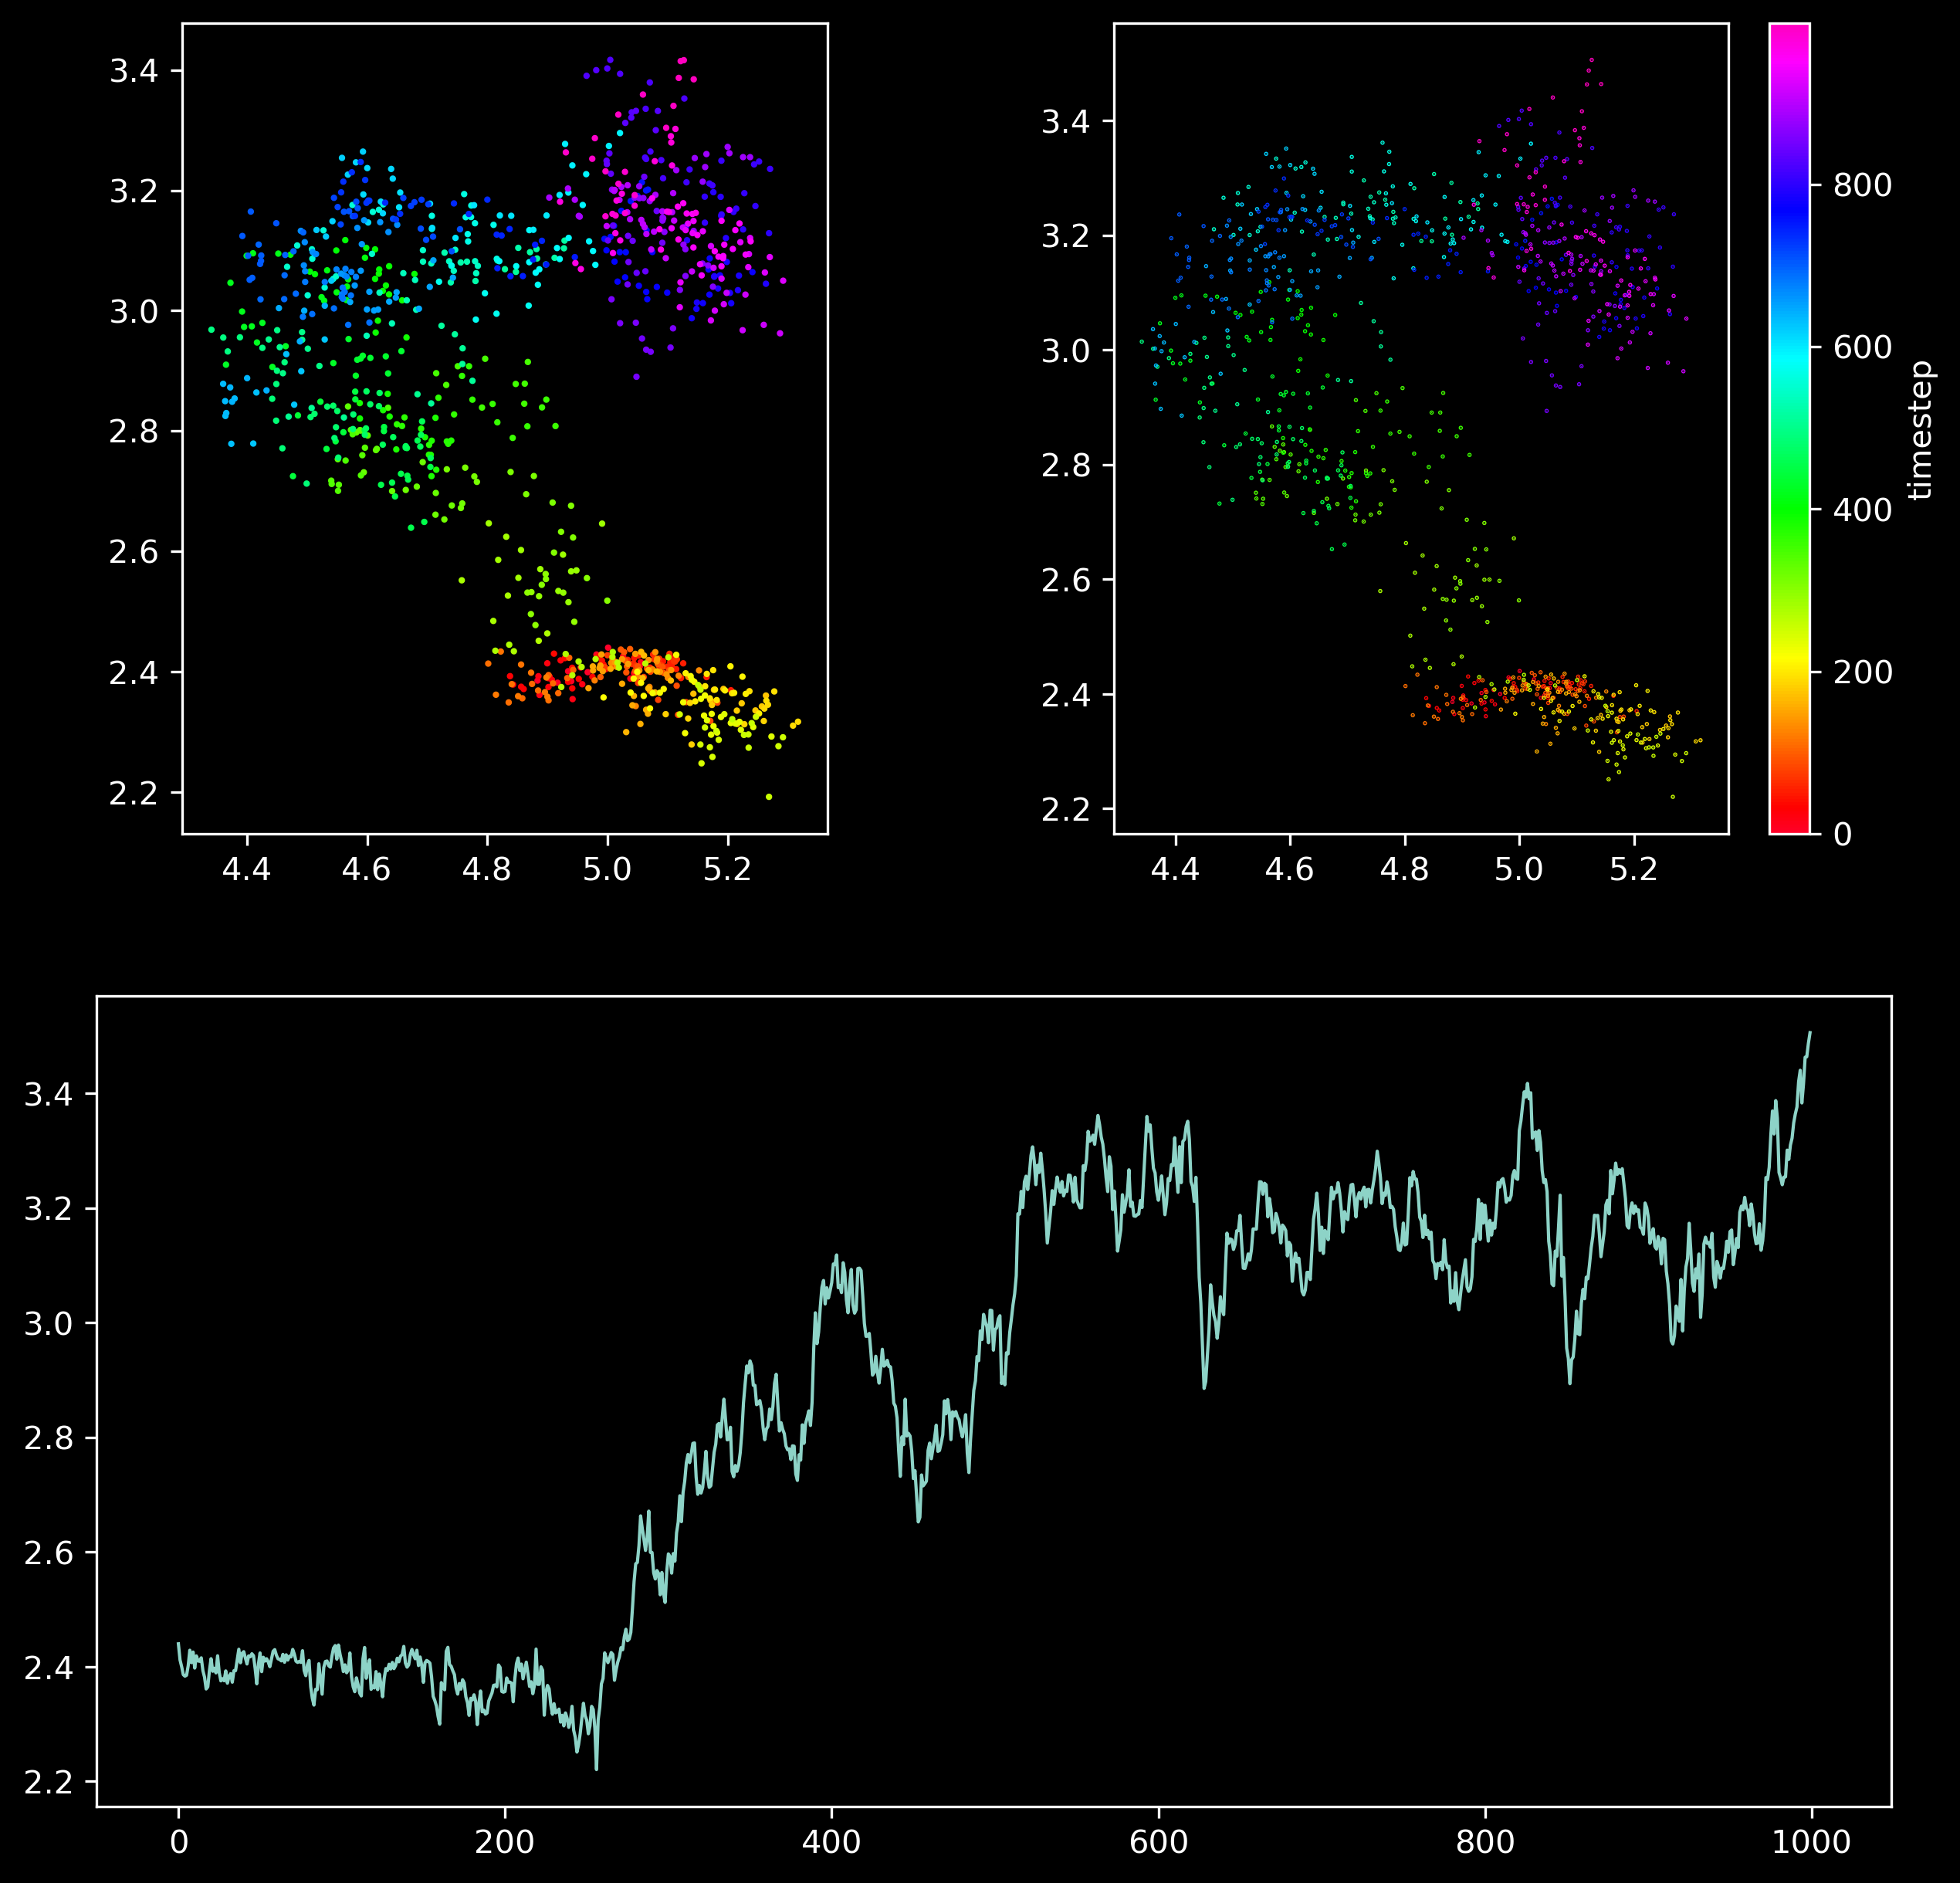

Elapsed (after compilation) = 24.53328670800147s
Engine 4:


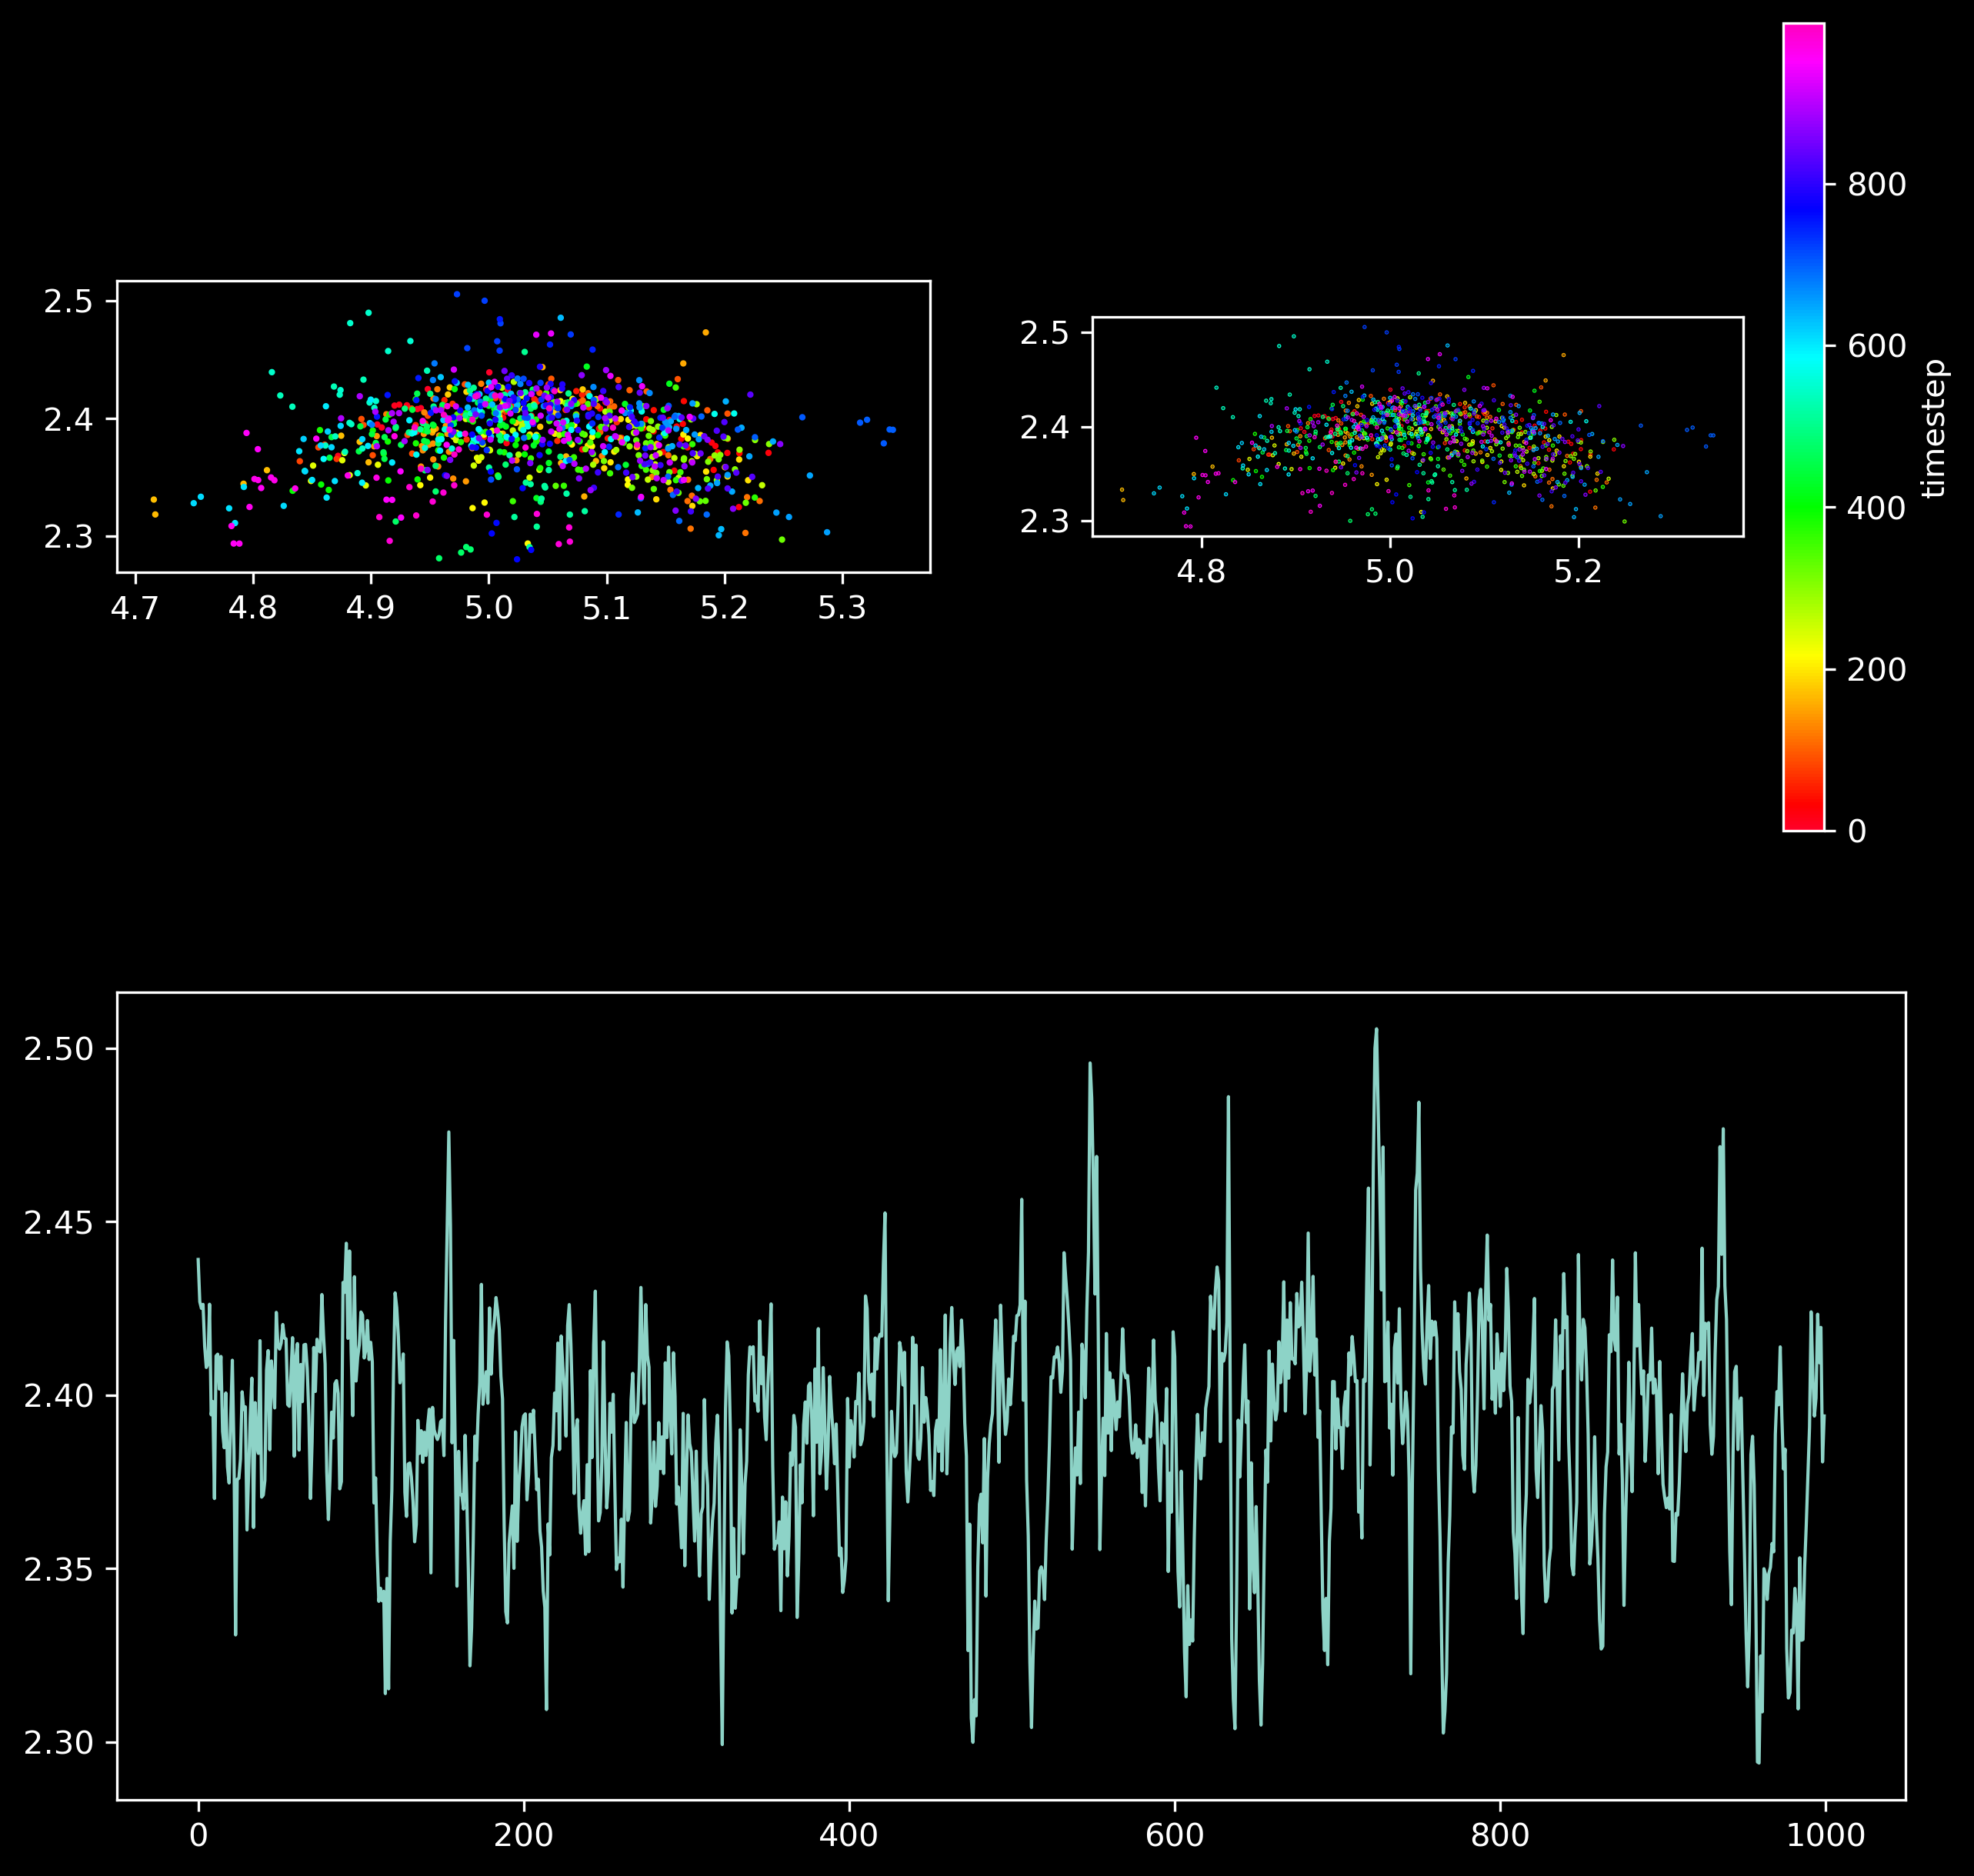

Elapsed (after compilation) = 24.811083583001164s
Engine 5:


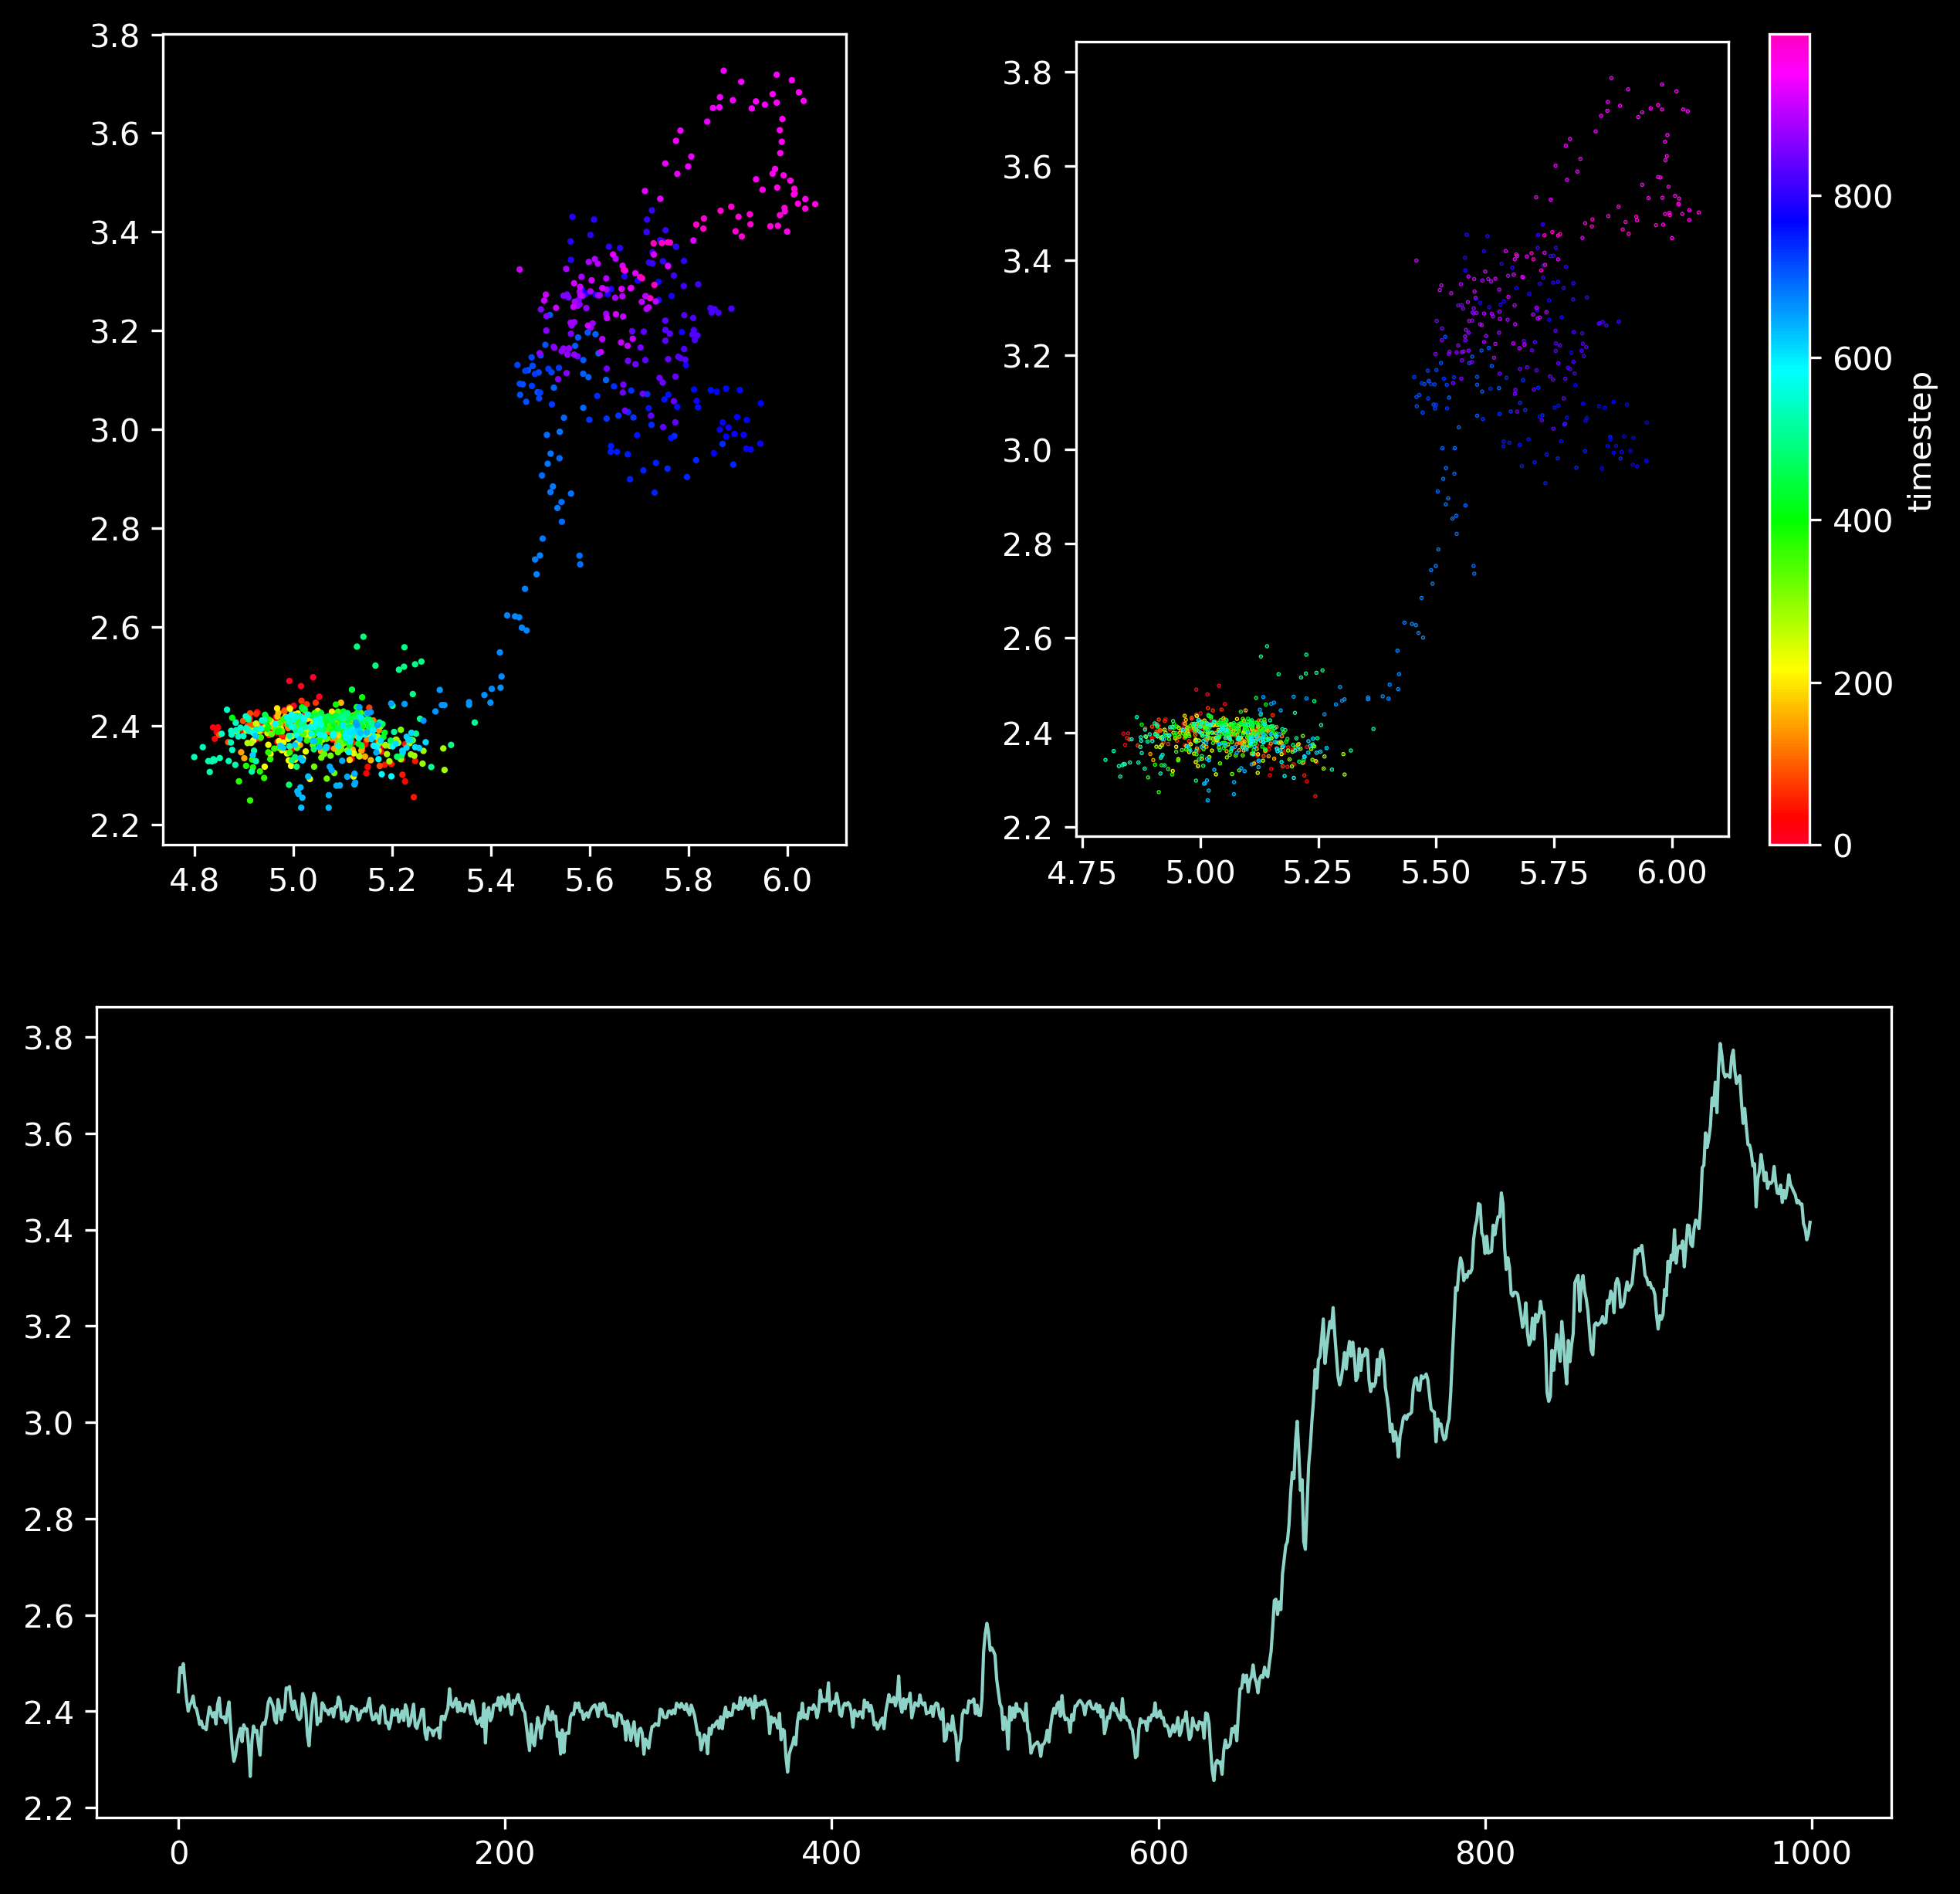

Elapsed (after compilation) = 24.86423383300098s


In [57]:
# Connect to the cluster (this assumes you have already started engines)
import os
import ipyparallel as ipp
import time

polymerLength = 10
headN = 1
steps = 10000000
dt = 0.001
random_val = 0.9
mu = 1
print_every = 1000000
hist_every = 10000

rc = ipp.Cluster(n=6).start_and_connect_sync()
dv = rc[:]
rc.ids
#rc = ipp.Client()
dview = rc[:]  # get a DirectView of all engines

# Push the necessary simulation functions and parameters to each engine.
# Adjust the names as needed to match your notebook's variables.
dview.push({
    'simulate': simulate,
    'polymergenerator': polymergenerator,
    'polymerLength': polymerLength,
    'headN': headN,
    'steps': steps,
    'dt': dt,
    'random_val': random_val,
    'mu': mu,
    'print_every': print_every,
    'hist_every': hist_every
})

with dview.sync_imports():
    import time

# Define a function that runs one simulation instance.
def run_simulation_instance():
    # Initialize the system.
    start = time.perf_counter()
    polymer, COM, surface, polymersurfaceP, polymersurfaceN = polymergenerator(polymerLength, headN)
    # Run the simulation (the entire simulation loop is compiled for speed).
    headhist, surfacehist = simulate(COM, surface, polymer, polymersurfaceP, polymersurfaceN, steps, dt, random_val, mu, print_every, hist_every)
    end = time.perf_counter()
    elapsed = end - start
    return {'headhist': headhist, 'surfacehist': surfacehist, 'elapsed': elapsed}


# Run one simulation instance on each engine in parallel.
async_results = dview.apply_async(run_simulation_instance)

# Wait for all to finish and gather the results.
results = async_results.get()
rc.shutdown(hub=True)

# For example, print the final COM from each simulation.
for idx, res in enumerate(results):
    print(f"Engine {idx}:")
    plotter(res['headhist'], idx, True)
    print("Elapsed (after compilation) = {}s".format((res['elapsed'])))


In [48]:
for idx, res in enumerate(results):
    with open(f"trajectoryn{idx}.xyz", "w") as f:
        for t, positions in enumerate(np.concatenate(((np.reshape(res['headhist'[::]],(int(steps/hist_every),1,3))), res['surfacehist'][::]),axis=1)):
            f.write(f"6 \n \n")
            f.write(f"C1 {positions[0,0]:8.4f}{positions[0,1]:8.4f}{positions[0,2]:8.4f} \n")
            f.write(f"C2 {positions[1,0]:8.4f}{positions[1,1]:8.4f}{positions[1,2]:8.4f} \n")
            f.write(f"C3 {positions[2,0]:8.4f}{positions[2,1]:8.4f}{positions[2,2]:8.4f} \n")
            f.write(f"C4 {positions[3,0]:8.4f}{positions[3,1]:8.4f}{positions[3,2]:8.4f} \n")
            f.write(f"C5 {positions[4,0]:8.4f}{positions[4,1]:8.4f}{positions[4,2]:8.4f} \n")
            f.write(f"C6 {positions[5,0]:8.4f}{positions[5,1]:8.4f}{positions[5,2]:8.4f} \n")